In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv("F:/subscription-churn-system/data/processed/train_features.csv")
valid = pd.read_csv("F:/subscription-churn-system/data/processed/valid_features.csv")

X_train = train.drop("churn_30d", axis=1)
y_train = train["churn_30d"]

X_valid = valid.drop("churn_30d", axis=1)
y_valid = valid["churn_30d"]

In [3]:
#Baseline #1 — Dummy Classifier (Reality Check)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

dummy_preds = dummy.predict_proba(X_valid)[:,1]
roc_auc_score(y_valid, dummy_preds)

0.5

In [6]:
#Baseline #2 — Logistic Regression with Scaling and Imputation

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # Import this

log_model = Pipeline([
    # Step 1: Fill missing values with the mean (or 'median')
    ("imputer", SimpleImputer(strategy="mean")), 
    
    # Step 2: Scale the data
    ("scaler", StandardScaler()),
    
    # Step 3: Train the model
    ("lr", LogisticRegression(max_iter=1000))
])

log_model.fit(X_train, y_train)

log_preds = log_model.predict_proba(X_valid)[:,1]

In [7]:
#Evaluate
from sklearn.metrics import roc_auc_score, average_precision_score

print("ROC-AUC:", roc_auc_score(y_valid, log_preds))
print("PR-AUC:", average_precision_score(y_valid, log_preds))

ROC-AUC: 0.9787234042553191
PR-AUC: 0.8680857817396462


In [9]:
#Final XGBoost Model
import xgboost as xgb

In [10]:
#Train Model
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    random_state=42
)

xgb.fit(X_train, y_train)
xgb_preds = xgb.predict_proba(X_valid)[:,1]

#Evaluate Final Model
print("ROC-AUC:", roc_auc_score(y_valid, xgb_preds))
print("PR-AUC:", average_precision_score(y_valid, xgb_preds))

ROC-AUC: 0.9775549890512142
PR-AUC: 0.8793120111304404


In [11]:
#Precision@K
def precision_at_k(y_true, y_scores, k=0.1):
    cutoff = int(len(y_scores) * k)
    top_k = np.argsort(y_scores)[-cutoff:]
    return y_true.iloc[top_k].mean()

for k in [0.05, 0.1, 0.2]:
    print(f"Precision@{int(k*100)}%:",
          precision_at_k(y_valid, xgb_preds, k))

Precision@5%: 0.9
Precision@10%: 0.5928571428571429
Precision@20%: 0.31316725978647686


In [12]:
#Tabular Comparison
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np

results = []

def precision_at_k(y_true, y_scores, k=0.1):
    cutoff = int(len(y_scores) * k)
    top_k_idx = np.argsort(y_scores)[-cutoff:]
    return y_true.iloc[top_k_idx].mean()

models = {
    "Dummy": dummy_preds,
    "Logistic Regression": log_preds,
    "XGBoost": xgb_preds
}

for name, preds in models.items():
    results.append({
        "Model": name,
        "ROC-AUC": roc_auc_score(y_valid, preds),
        "PR-AUC": average_precision_score(y_valid, preds),
        "Precision@5%": precision_at_k(y_valid, preds, 0.05),
        "Precision@10%": precision_at_k(y_valid, preds, 0.10),
        "Precision@20%": precision_at_k(y_valid, preds, 0.20)
    })

results_df = pd.DataFrame(results).round(3)
results_df

,Model,ROC-AUC,PR-AUC,Precision@5%,Precision@10%,Precision@20%
0,Dummy,0.500,0.066,0.157,0.143,0.114
1,Logistic Regression,0.979,0.868,0.886,0.586,0.320
2,XGBoost,0.978,0.879,0.900,0.593,0.313


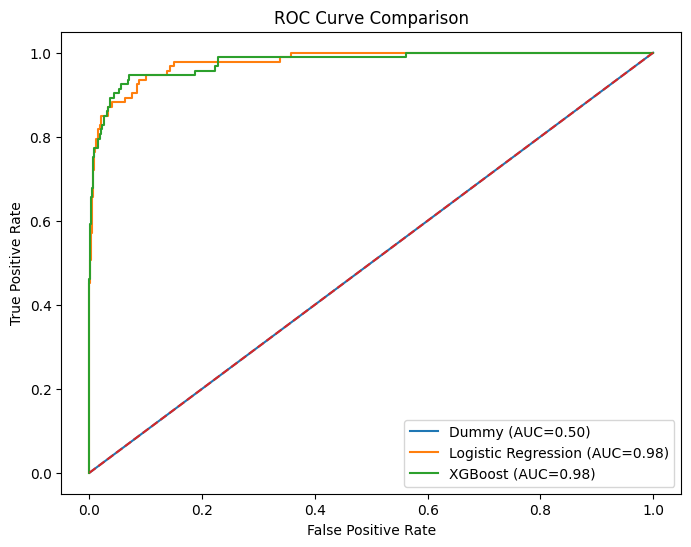

In [13]:
#Graphical Comparison
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for name, preds in models.items():
    fpr, tpr, _ = roc_curve(y_valid, preds)
    auc = roc_auc_score(y_valid, preds)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


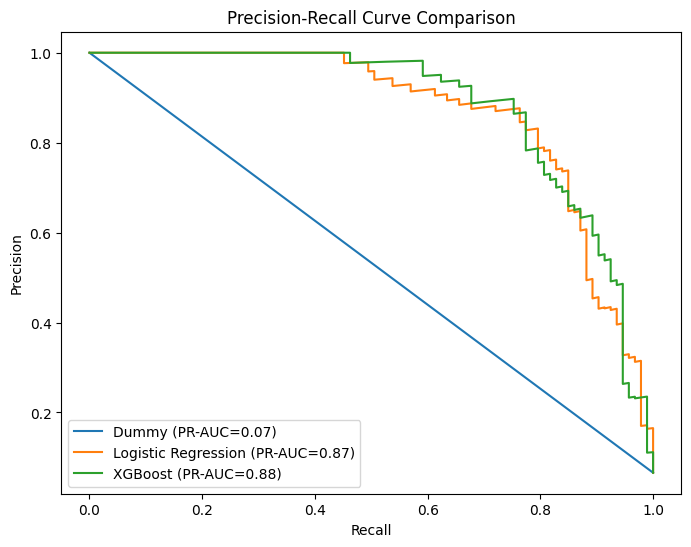

In [14]:
#Precision-Recall Curve Comparison
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8,6))

for name, preds in models.items():
    precision, recall, _ = precision_recall_curve(y_valid, preds)
    pr_auc = average_precision_score(y_valid, preds)
    plt.plot(recall, precision, label=f"{name} (PR-AUC={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()

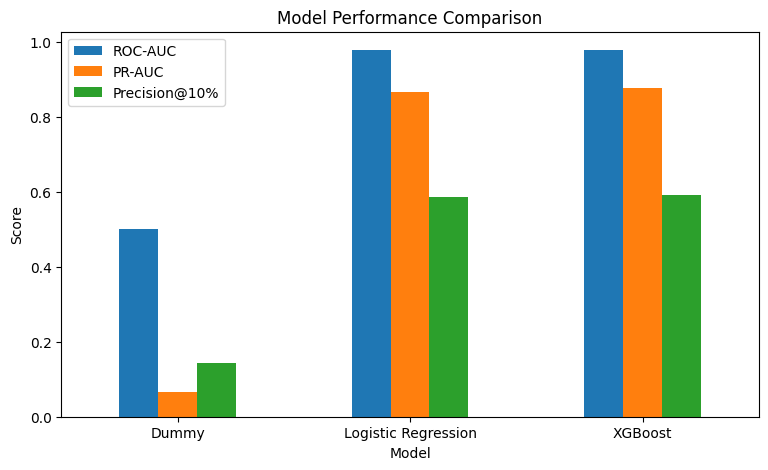

In [15]:
#Bar Chart
metrics_to_plot = results_df.set_index("Model")[["ROC-AUC", "PR-AUC", "Precision@10%"]]

metrics_to_plot.plot(kind="bar", figsize=(9,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

In [16]:
import joblib
joblib.dump(xgb, "F:/subscription-churn-system/models/xgboost_churn.pkl")

['F:/subscription-churn-system/models/xgboost_churn.pkl']